#   HOUSE PRICE PREDICTION NOTEBOOK

## Import Libraries

In [31]:
import os, glob, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost

import warnings
warnings.filterwarnings("ignore")


from Functions.preprocessing import *
from Functions.visualization import *

## Get the Data

In [2]:
TRAINDATAPATH = f'{os.getcwd()}/Data/train.csv'
TESTDATAPATH = f'{os.getcwd()}/Data/test.csv'

In [3]:
dfTrain=pd.read_csv(TRAINDATAPATH)
dfTest=pd.read_csv(TESTDATAPATH)

In [4]:
dfTrain

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Descriptive Analysis

In [5]:
dfTrain.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [6]:
dfTrain["SalePrice"] = np.log10(dfTrain["SalePrice"])

In [7]:
dfNumeric = dfTrain.select_dtypes(["int64", "float64"])
dfObject = dfTrain.select_dtypes("object")

In [8]:
dfObject = handleNans(dfObject, ratio=0.2)
dfNumeric = handleNans(dfNumeric, ratio=0.2)

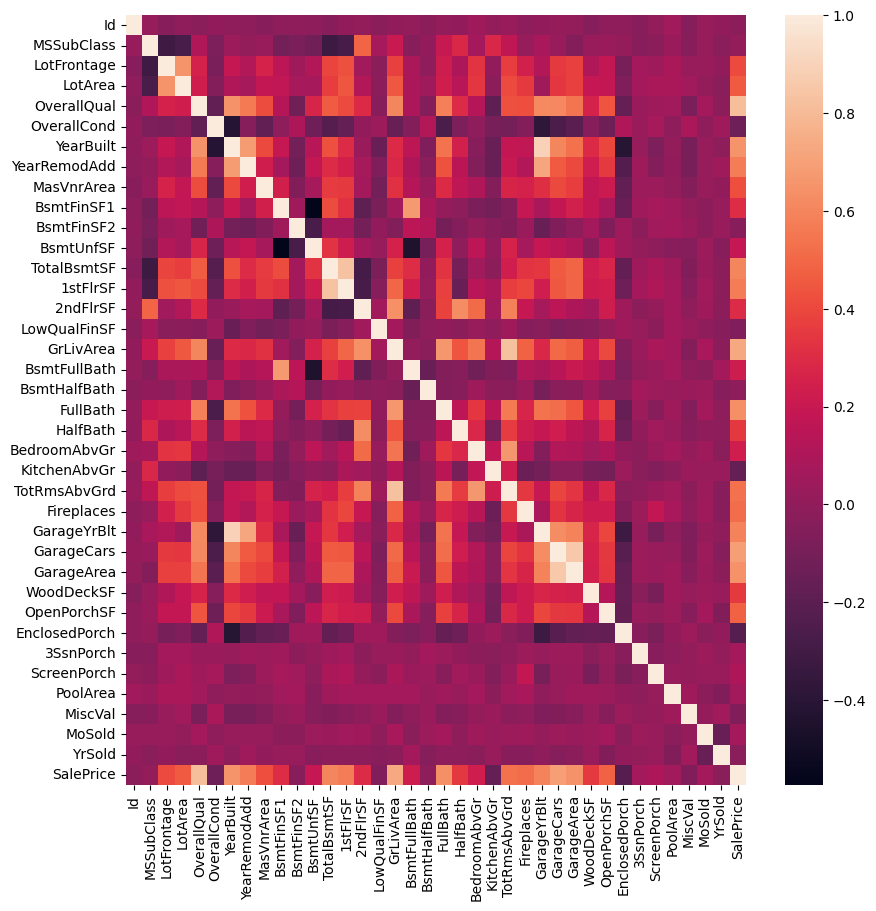

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(dfNumeric.corr(method="spearman"), ax=ax)
plt.show()

In [10]:
dfObject["SalePrice"] = dfNumeric["SalePrice"]

In [11]:
dfObject, _ = mergeSmallCategories(dfObject)

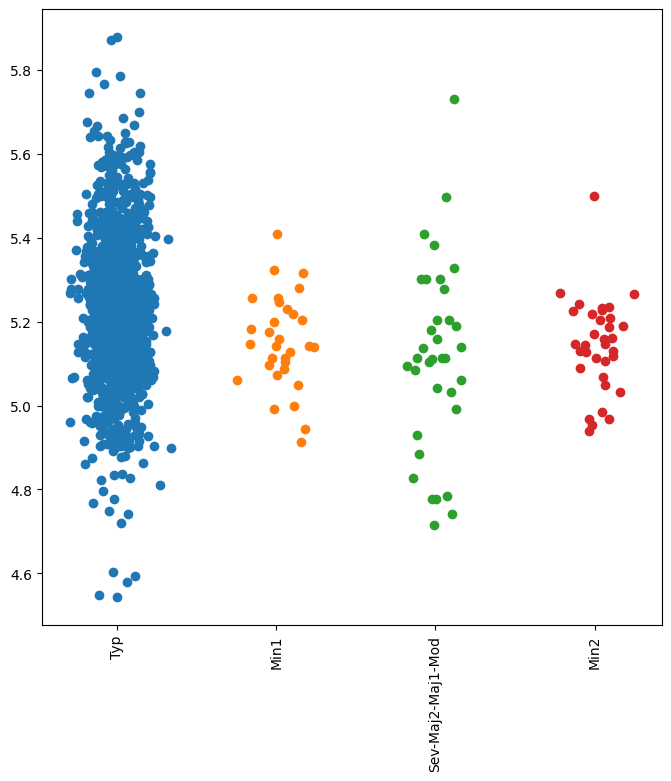

In [12]:
ax = visualizeByGroup(dfObject, "Functional")
plt.show()

In [13]:
dfNumeric, _ = fillNumericNans(dfNumeric)

LotFrontage
-----------
* (594.4183057403079, 589.2581203146698) 

GarageYrBlt
-----------
* (164.0201376316391, 609.1404623690802) 

MasVnrArea
----------
* Added Mean



In [14]:
dfObject = dfObject.fillna("Unknown")

In [20]:
def encode(dataframe:pd.DataFrame) -> pd.DataFrame:
    df_ = dataframe.copy()
    df = df_.select_dtypes("object")
    labelSeries = df_.loc[:, ~df_.columns.isin(df.columns)]

    enc = OneHotEncoder(drop="first", sparse=False)
    encodedMatrix =  enc.fit_transform(df)
    dfEncoded = pd.DataFrame(encodedMatrix, columns=enc.get_feature_names_out())
    return pd.concat([dfEncoded, labelSeries], axis=1), enc

dfObject, _ = encode(dfObject)

In [23]:
dfObject.drop(["SalePrice"], axis=1, inplace=True)

In [26]:
dfMerged = dfObject.merge(dfNumeric, left_index=True, right_index=True)

In [40]:
regressorCols = dfMerged.loc[:, ~dfMerged.columns.isin(["SalePrice"])].columns
errs = []

for train, test in KFold(9, shuffle=True, random_state=42).split(dfMerged):
    X_train, X_test, y_train, y_test = dfMerged.iloc[train][regressorCols], dfMerged.iloc[test][regressorCols], dfMerged.iloc[train]["SalePrice"], dfMerged.iloc[test]["SalePrice"]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    err = mean_squared_error(y_test, preds)
    errs.append(10**err)

print("MSE is:", np.array(errs).mean())

MSE is: 1.0078445194293455
